<a href="https://colab.research.google.com/github/ingridheuer/GCNN_for_GDAs/blob/main/exploration/notebooks/RSAGE_nofeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalo e importo librerias

In [1]:
import torch
print(torch.__version__)
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

1.12.0+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 7.9 MB 4.9 MB/s 
     |████████████████████████████████| 3.5 MB 58.4 MB/s 


In [91]:
#Librería base de redes neuronales de torch
#Acá están las clases "base" de las que heredan todos los modelos
import torch.nn as nn

#Operaciones entre sparse matrix
from torch_sparse import matmul, SparseTensor

#Librerías específicas de GNNs: 
#PYG es la libraría general de GNNs,
#DeepSNAP tiene utilidades para el manejo de datos y grafos heterogeneos, hacer splits, negative sampling, etc.
import torch_geometric.nn as pyg_nn
from torch_geometric.nn import HeteroConv
from deepsnap.dataset import GraphDataset
import deepsnap.hetero_gnn
from deepsnap.hetero_gnn import forward_op
from deepsnap.hetero_graph import HeteroGraph
from torch_geometric.utils import to_undirected
import torch.nn.functional as F

#Para manejar los minibatches (todavía no lo estoy usando)
#from torch.utils.data import DataLoader
#from deepsnap.batch import Batch

from timeit import default_timer as timer
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import copy
import datetime
import pickle

#Utils

Funciones de utilidad que arme a medida que implementaba el modelo.

In [102]:
def get_prediction(model,H:HeteroGraph) -> dict:
    """Hacer un forward pass sin entrenar para hacer una predicción. Devuelve los puntajes ya traducidos a 0,1"""
    prediction = {}
    with torch.no_grad():
        preds = model(H)
        for key,pred in preds.items():
            logits = torch.sigmoid(pred)
            pred_label = torch.round(logits)
            prediction[key] = pred_label
    return prediction

def get_edge_data(H:HeteroGraph, type:tuple) -> dict:
    """Dado un objeto HeteroGraph y un tipo de enlace ('type_n1','type_edge','type_n2'), devuelve un diccionario con datos de cada enlace.
    El formato es (n1,n2): {attr dict}"""

    edges = list(H.G.edges(data=True))
    edge_mapping = H.edge_to_graph_mapping[type].tolist()
    #data = {(edges[idx][0], edges[idx][1]):edges[idx][2] for j,idx in edge_mapping}
    data = {j:{"graph_idx":idx, "edge": (edges[idx][0],edges[idx][1]), "attr":edges[idx][2]} for j,idx in enumerate(edge_mapping)}
    return data

def get_node_data(H:HeteroGraph, type:str) -> dict:
    """Dado un objeto HeteroGraph y un tipo de nodo "node_type" nos devuelve un diccionario con los datos de cada nodo, indexado por el índice que tiene
    en el HeteroGraph, que son tensores!
    El formato es: {tensor idx: {attribute dict})}"""

    nodes = dict(H.G.nodes(data=True))
    node_mapping = H.node_to_graph_mapping[type].tolist()
    data = {j:{"data":nodes[idx], "graph_idx":idx} for j,idx in enumerate(node_mapping)}
    return data

def check_same_edges(H:HeteroGraph, type1:tuple, type2:tuple) -> bool:
    """Verifica que dos tipos de enlace en un HeteroGraph tengan los mismos enlaces pero invertidos"""

    edges1 = list(get_edge_data(H,type1).keys())
    edges2 = list(get_edge_data(H,type2).keys())
    reversed_1 = [tuple(reversed(edge)) for edge in edges1]
    return set(reversed_1) == set(edges2)

def tensor_to_edgelist(tensor: torch.tensor) -> list:
  """Toma un edge_index tensor de shape (2,num_edges) y devuelve una lista de tuplas [(n1,n2)]"""

  sources = tensor[0,:].tolist()
  targets = tensor[1,:].tolist()
  edgelist = list(zip(sources,targets))
  return edgelist

def init_node_features(G, mode, size):
  """ Toma un objeto nx.Graph, un modo de inicialización y dimensión. Genera para cada nodo el tensor de features correspondiente y se lo asigna
  como atributo en el grafo"""

  if mode == "ones":
    feature = torch.ones(size)
    nx.set_node_attributes(G, feature, 'node_feature')
  elif mode == "random":
    feature_dict = {}
    for node in list(G.nodes()):
      feature_dict[node] = torch.rand(size)
    nx.set_node_attributes(G,feature_dict,'node_feature')

def map_prediction_to_edges(prediction:torch.tensor,H:HeteroGraph, edge_to_label = True) -> dict:
  """Dada una predicción, devuelve un diccionario que mapea el edge (u,v) a la etiqueta predecida.
  El mapa corresponde a los enlaces en el dataset usado: si se predijo sobre val, pasar dataset val al argument
  esto es importante porque los indices no se conservan en los splits
  if edge_to_label el dict es {(u,v):label}, sino es {label:[(u,v),...]}"""

  prediction_map = {}
  for edge_type,pred in prediction.items():
    predicted_labels = pred.tolist()
    labeled_edges = tensor_to_edgelist(H.edge_label_index[edge_type])
    pred_map = {edge:label for edge,label in zip(labeled_edges,predicted_labels)}
    if edge_to_label:
      prediction_map[edge_type] = pred_map
    else:
      positives = [edge for edge,val in pred_map.items() if val==1]
      negatives = [edge for edge,val in pred_map.items() if val==0]
      prediction_map[edge_type] = {1:positives, 0:negatives}
  return prediction_map

def get_edge(data:pd.DataFrame,edge:tuple):
    """Dado un enlace en forma de tupla (n1,n2) y el dataframe edge_data, recupera la fila correspondiente
    Si el enlace existe pero invertido, devuelve esa fila"""

    row = edge_data[(data.a_idx == edge[0]) & (data.b_idx == edge[1])]
    if row.empty:
      row = edge_data[(data.a_idx == edge[1]) & (data.b_idx == edge[0])]
      if row.empty:
        print("Edge does not exist in dataframe")
    return row

def get_prediction_data_dict(prediction,dataset,nodes_data)-> dict:
  """Dado un tensor de predicción, devuelve un diccionario indexado por edges (n1,n2) que es más legible. 
  El tensor de input es una predicción en formato torch.tensor([1,0,1,....]). Los indices de ese tensor corresponden a los indices del enlace.
  Esos índices dependen del grafo del cual salieron, por eso hay que también pasar el dataset como argumento
  Esta función traduce esos índices a enlaces y busca sus datos, devuelve todo en un diccionario"""

  results = {}
  edge_to_label_dict = map_prediction_to_edges(prediction,dataset)
  for edgetype,pred in edge_to_label_dict.items():
    src_type = edgetype[0]
    trg_type = edgetype[2]
    src_info = nodes_data[src_type]
    trg_info = nodes_data[trg_type]
    edgetype_results = {edge:{"source_data":src_info[edge[0]], "target_data":trg_info[edge[1]], "label":label} for edge,label in pred.items()}
    results[edgetype] = edgetype_results
  return results

def get_prediction_dataframe(prediction,dataset)-> dict:
  """Dado un tensor de predicción, devuelve un dataframe con un enlace por fila y su info.
  El tensor de input es una predicción en formato torch.tensor([1,0,1...]). Los índices de ese tensor corresponden a los indices del enlace.
  Esos índices dependen del grafo del cual salieron, por eso hay que también pasar el dataset como argumento
  Esta función traduce los indices a enlaces y busca sus datos, devuelve todo en un dataframe"""

  #TODO: agregar una columna de score
  results = {}
  edge_to_label_dict = map_prediction_to_edges(prediction,dataset)
  for edgetype,pred in edge_to_label_dict.items():
    src_type, relation, trg_type = edgetype
    src_info = get_node_data(dataset,src_type)
    trg_info = get_node_data(dataset,trg_type)
    for edge, label in pred.items():
      src,trg = edge
      results[edge] = {"type":relation,"source_idx":src_info[src]["data"]["node_dataset_idx"],"target_idx":trg_info[trg]["data"]["node_dataset_idx"],"source_type":src_info[src]["data"]["node_type"],"target_type":trg_info[trg]["data"]["node_type"],"source_name":src_info[src]["data"]["node_name"], "target_name":trg_info[trg]["data"]["node_name"] ,"label":label}
    frame = pd.DataFrame.from_dict(results, orient="index")
  return frame

def edgeindex_to_sparsematrix(het_graph: HeteroGraph) -> dict :
    """Toma un edge_index en formato torch.tensor con shape (2,num_edges) y devuelve la matriz de adyacencia corresponiente como sparse matrix"""

    sparse_edge_dict = {}
    for key in het_graph.edge_index:
        temp_edge_index = het_graph.edge_index[key]
        from_type = key[0]
        to_type = key[2]
        adj = SparseTensor(row=temp_edge_index[0], col=temp_edge_index[1], sparse_sizes=(het_graph.num_nodes(from_type), het_graph.num_nodes(to_type)))
        sparse_edge_dict[key] = adj.t()
    return sparse_edge_dict

def init_node_feature_map(G, mode, size):
  """ Dado un grafo de nx.Graph, un modo y dimensión de inicialización de feature, devuelve un diccionario que le asigna
  una feature a cada nodo del grafo """

  if mode == "ones":
    feature = torch.ones(size)
    feature_dict = {node:feature for node in list(G.nodes())}
  elif mode == "random":
    feature_dict = {}
    for node in list(G.nodes()):
      feature_dict[node] = torch.rand(size)
  return feature_dict

def generate_features(G,modes_sizes:dict) -> dict:
  """Dado un grafo de nx.Graph y un diccionario {mode:[sizes]} genera un diccionario que asigna a cada nodo laS features correspondientes"""

  feature_dict = {}
  for mode,sizes in modes_sizes.items():
    for size in sizes:
      feature_map = init_node_feature_map(G,mode,size)
      feature_dict[(mode,size)] = feature_map
  return feature_dict

def init_multiple_features(G,modes_sizes:dict) -> dict:
  """Dado un grafo de nx.Graph y diccionario {mode:[sizes]} inicializa y asigna a cada nodo laS features correspondientes.
  Ejemplo de dict: {"ones":[1,2,3], "random":[1,2,3]}. Las claves asignadas a cada attr van a ser strings "mode_length" """

  for mode,sizes in modes_sizes.items():
    for size in sizes:
      feature_map = init_node_feature_map(G,mode,size)
      nx.set_node_attributes(G,feature_map,f"{mode}_{size}")

def set_feature(split,init_mode,feature_length):
  """Modifica el atributo .node_feature de un HeteroGraph. In place"""

  feature_key = f"{init_mode}_{feature_length}"
  split.__setattr__("node_feature",split[feature_key])

def save_results(result_dict,filename):
    """Guarda un diccionario de resultados en formato pickle"""
    with open(filename +'.pickle', 'wb') as f:
        pickle.dump(result_dict, f, pickle.HIGHEST_PROTOCOL)


# Modelo

Arquitectura del modelo

In [5]:
class distmult_head(torch.nn.Module):
  def __init__(self, hetero_graph, hidden_size):
    super().__init__()
    self.R_weights = nn.ParameterDict()

    for edge_type in hetero_graph.edge_types:
      self.R_weights[edge_type] = nn.Parameter(torch.rand(hidden_size,hidden_size)*0.01)
  
  def score(self,x,edge_label_index):
    scores = {}
    for message_type in edge_label_index:
      src_type,edge_type,trg_type = message_type[0], message_type[1], message_type[2]
      rel_weights = self.R_weights[edge_type]
      nodes_left = torch.index_select(x[src_type], 0, edge_label_index[message_type][0,:].long())
      nodes_right = torch.index_select(x[trg_type], 0, edge_label_index[message_type][1,:].long())
      mid_product = nodes_right@rel_weights
      scores[message_type] = torch.sum(mid_product@torch.t(nodes_left) , dim=-1)
    return scores

In [103]:
class HeteroGNNConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels_src, in_channels_dst, out_channels):
        super().__init__(aggr="mean")

        self.in_channels_src = in_channels_src
        self.in_channels_dst = in_channels_dst
        self.out_channels = out_channels
        self.lin_dst = nn.Linear(in_channels_dst, out_channels)
        self.lin_src = nn.Linear(in_channels_src, out_channels)
        self.lin_update = nn.Linear(2*out_channels, out_channels)

    def forward(
            self,
            node_feature_src,
            node_feature_dst,
            edge_index,
            size=None):

        out = self.propagate(edge_index, size, node_feature_src=node_feature_src, node_feature_dst=node_feature_dst)
        return out

    def message_and_aggregate(self, edge_index, node_feature_src):
        out = matmul(edge_index, node_feature_src, reduce=self.aggr)
        return out

    def update(self, aggr_out, node_feature_dst):
        dst_msg = self.lin_dst(node_feature_dst)
        src_msg = self.lin_src(aggr_out)
        full_msg = torch.concat((dst_msg, src_msg), dim=-1)
        out = self.lin_update(full_msg)
        return out


class HeteroGNNWrapperConv(deepsnap.hetero_gnn.HeteroConv):
    def __init__(self, convs, args, aggr="mean"):
        super().__init__(convs, None)
        self.aggr = aggr

        # Map the index and message type
        self.mapping = {}

    def reset_parameters(self):
        super().reset_parameters()

    def forward(self, node_features, edge_indices):
        message_type_emb = {}

        for message_key, message_type in edge_indices.items():
            src_type, edge_type, dst_type = message_key
            node_feature_src = node_features[src_type]
            node_feature_dst = node_features[dst_type]
            edge_index = edge_indices[message_key]
            message_type_emb[message_key] = (self.convs[message_key](node_feature_src,node_feature_dst,edge_index))

        node_emb = {dst: [] for _, _, dst in message_type_emb.keys()}
        mapping = {}

        for (src, edge_type, dst), item in message_type_emb.items():
            mapping[len(node_emb[dst])] = (src, edge_type, dst)
            node_emb[dst].append(item)
        self.mapping = mapping
        for node_type, embs in node_emb.items():
            if len(embs) == 1:
                node_emb[node_type] = embs[0]
            else:
                node_emb[node_type] = self.aggregate(embs)
        return node_emb

    def aggregate(self, xs):
        return torch.mean(torch.stack(xs, dim=-1), dim=-1)

def generate_convs(hetero_graph, conv, hidden_size, first_layer=False):
    convs = {}

    msg_types = hetero_graph.message_types
    for key in msg_types:
        if first_layer:
            dst_feature_dim = hetero_graph.num_node_features(key[2])
            src_feature_dim = hetero_graph.num_node_features(key[0])
            convs[key] = conv(src_feature_dim, dst_feature_dim, hidden_size)
        else:
            convs[key] = conv(hidden_size, hidden_size, hidden_size)

    return convs


class HeteroGNN(torch.nn.Module):
    def __init__(self, hetero_graph, head, pred_mode, args, aggr="mean"):
        super().__init__()

        self.aggr = aggr
        self.head = head
        self.pred_mode = pred_mode
        self.hidden_size = args['hidden_size']
        self.bns1 = torch.nn.ModuleDict()
        self.bns2 = torch.nn.ModuleDict()
        self.relus1 = torch.nn.ModuleDict()
        self.relus2 = torch.nn.ModuleDict()
        self.loss_fn = torch.nn.BCEWithLogitsLoss()
        
        if head=="dismult":
          self.distmult_head = distmult_head(hetero_graph,self.hidden_size)

        convs1 = generate_convs(hetero_graph, HeteroGNNConv, self.hidden_size, first_layer=True)
        convs2 = generate_convs(hetero_graph, HeteroGNNConv, self.hidden_size, first_layer=False)
        self.convs1 = HeteroGNNWrapperConv(convs1, args, aggr=self.aggr)
        self.convs2 = HeteroGNNWrapperConv(convs2, args, aggr=self.aggr)
        for node_type in hetero_graph.node_types:
            self.bns1[node_type] = torch.nn.BatchNorm1d(self.hidden_size)
            self.bns2[node_type] = torch.nn.BatchNorm1d(self.hidden_size)
            self.relus1[node_type] = torch.nn.LeakyReLU()
            self.relus2[node_type] = torch.nn.LeakyReLU()

    def forward(self, graph):
        x, edge_label_index = graph.node_feature, graph.edge_label_index
        adj = edgeindex_to_sparsematrix(graph)
        x = self.convs1(x, edge_indices=adj)
        x = deepsnap.hetero_gnn.forward_op(x, self.bns1)
        x = deepsnap.hetero_gnn.forward_op(x, self.relus1)
        x = self.convs2(x, edge_indices=adj)
        x = deepsnap.hetero_gnn.forward_op(x, self.bns2)


        if self.head == "dotprod":
          pred = {}
          if self.pred_mode == "all":
            for message_type in edge_label_index:
                src_type = message_type[0]
                trg_type = message_type[2]
                nodes_first = torch.index_select(x[src_type], 0, edge_label_index[message_type][0,:].long())
                nodes_second = torch.index_select(x[trg_type], 0, edge_label_index[message_type][1,:].long())
                pred[message_type] = torch.sum(nodes_first * nodes_second, dim=-1)
          elif self.pred_mode == "gda_only":
            keys = [('gene/protein', 'GDA', 'disease'), ('disease', 'GDA', 'gene/protein')]
            for message_type in keys:
              src_type = message_type[0]
              trg_type = message_type[2]
              nodes_first = torch.index_select(x[src_type], 0, edge_label_index[message_type][0,:].long())
              nodes_second = torch.index_select(x[trg_type], 0, edge_label_index[message_type][1,:].long())
              pred[message_type] = torch.sum(nodes_first * nodes_second, dim=-1)
          return pred
        elif self.head == "distmult":
          return self.distmult_head.score(x,edge_label_index)
          
    def loss(self, pred, y):
        loss = 0
        sets = torch.tensor(len(pred.keys()))
        for key in pred:
            p = pred[key]
            loss += self.loss_fn(p, y[key].type(pred[key].dtype))
        return loss

# Funciones de entrenamiento y evaluación

In [109]:
def train(model, optimizer, graph, printb):
    model.train()
    optimizer.zero_grad()
    preds = model(graph)
    loss = model.loss(preds, graph.edge_label)
    loss.backward()
    optimizer.step()
    acc = 0
    num = 0
    for key,pred in preds.items():
      logits = torch.sigmoid(pred)
      pred_label = torch.round(logits)
      acc += (pred_label == graph.edge_label[key]).sum().item()
      num += pred_label.shape[0]
    accuracy = acc/num
    if printb:
        print(loss.item())
    return loss.item(), accuracy

def test(model,validation_set,global_accuracy=True):
  model.eval()
  if global_accuracy:
    acc = 0
    num = 0
    with torch.no_grad():
      preds = model(validation_set)
      for key,pred in preds.items():
        logits = torch.sigmoid(pred)
        pred_label = torch.round(logits)
        acc += (pred_label == validation_set.edge_label[key]).sum().item()
        num += pred_label.shape[0]
    accuracy = round(acc/num,3)
    return accuracy
  else:
    type_accuracy = {}
    with torch.no_grad():
      preds = model(validation_set)
      for key,pred in preds.items():
        logits = torch.sigmoid(pred)
        pred_label = torch.round(logits)
        acc = (pred_label == validation_set.edge_label[key]).sum().item()
        num = pred_label.shape[0]
        type_accuracy[key] = round(acc/num,3)
    return type_accuracy

def hits_at_k(model,dataset,k,return_indices=False) -> dict:
  hits = {}
  with torch.no_grad():
    preds = model(dataset)
    for key,pred in preds.items():
        #ordeno los puntajes de mayor a menor
        pred, indices = torch.sort(pred, descending=True)

        #corto el ranking en 0.5
        pred = pred[pred>0.5]

        #me quedo solo con los k mayor punteados
        if pred.shape[0]>k:
          pred, indices = pred[:k].to(args["device"]), indices[:k].to(args["device"])
        else:
          print(f"Top {k} scores below classification threshold 0.5, returning top {pred.shape[0]}")

        #busco que label tenían esas k preds
        labels = torch.index_select(dataset.edge_label[key],-1,indices)

        #cuento cuantas veces predije uno positivo en el top k
        if return_indices:
          #devuelvo los indices por si quiero ir a buscar los enlaces al grafo
          hits[key] = {"hits":labels.sum().item(),"indices":indices}
        else:
          #si solo quiero contar hits no devuelvo indices
          hits[key] = {"hits":labels.sum().item()}

  return hits

# Preprocesamiento del dataset

Cargo los datos y armo el grafo

In [7]:
node_data = pd.read_csv("/content/graph_node_table.csv", index_col=0)
edge_data = pd.read_csv("/content/graph_edge_table.csv",index_col=0).rename(columns={"relation":"edge_type"})

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
display(node_data.head())
display(edge_data.head())

,node_idx,node_id,node_type,node_name,node_source
1,1,1,gene/protein,A1BG,disgenet
2,2,2,gene/protein,A2M,disgenet
3,3,9,gene/protein,NAT1,disgenet
4,4,10,gene/protein,NAT2,disgenet
5,5,12,gene/protein,SERPINA3,disgenet


,edge_idx,a_idx,b_idx,a_id,b_id,edge_type,a_type,b_type,source,source_idx
1,1,1839,14989,3440,C0000737,GDA,gene/protein,disease,disgenet,26518
2,2,2389,15912,4547,C0000744,GDA,gene/protein,disease,disgenet,34865
3,3,5236,10506,10683,C0000768,GDA,gene/protein,disease,disgenet,63589
4,4,724,10506,1295,C0000768,GDA,gene/protein,disease,disgenet,11121
5,5,741,10506,1317,C0000768,GDA,gene/protein,disease,disgenet,11360


In [105]:
D = nx.from_pandas_edgelist(edge_data,source="a_idx",target="b_idx", edge_attr="edge_type")
nx.set_node_attributes(D,pd.Series(node_data.node_type, index=node_data.node_idx).to_dict(),"node_type")
nx.set_node_attributes(D,pd.Series(node_data.node_name, index=node_data.node_idx).to_dict(),"node_name")
nx.set_node_attributes(D,pd.Series(node_data.node_idx, index=node_data.node_idx).to_dict(),"node_dataset_idx")
#nx.set_edge_attributes(D,pd.Series(edge_data.edge_idx, index=edge_data.edge_idx).to_list(), "edge_dataset_idx")

G = D.to_directed()

Exploro los datos

In [106]:
list(G.nodes(data=True))[0]

(1839,
 {'node_dataset_idx': 1839, 'node_name': 'IFNA2', 'node_type': 'gene/protein'})

In [107]:
node_id = 5
print(f"Node {node_id} has properties:", G.nodes(data=True)[node_id])
edges = list(G.edges())
edge_idx = 123456
n1 = edges[edge_idx][0]
n2 = edges[edge_idx][1]
edge = list(G.edges(data=True))[edge_idx]
print(f"Edge ({edge[0]}, {edge[1]}) has properties:", edge[2])
print(f"Node {n1} has properties:", G.nodes(data=True)[n1])
print(f"Node {n2} has properties:", G.nodes(data=True)[n2])

Node 5 has properties: {'node_type': 'gene/protein', 'node_name': 'SERPINA3', 'node_dataset_idx': 5}
Edge (2725, 21665) has properties: {'edge_type': 'PPI'}
Node 2725 has properties: {'node_type': 'gene/protein', 'node_name': 'PDPK1', 'node_dataset_idx': 2725}
Node 21665 has properties: {'node_type': 'gene/protein', 'node_name': 'CDC37_HUMAN', 'node_dataset_idx': 21665}


In [108]:
G.number_of_edges()

497241

# Optimización


Experimento con distintas inicializaciones, formas de supervisión y dimensión de features

In [111]:
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'hidden_size': 32,
    'weight_decay': 1e-5,
    'lr': 0.001,
    'epochs':100,
    'k_hits':[5,10,20,50]
}

In [110]:
#placeholder feature:
nx.set_node_attributes(G,[],"node_feature")
#inicializo features
init_multiple_features(G,{"random":[5,10,50,100,500]})
Hete = HeteroGraph(G)

task = 'link_pred'
train_mode = "disjoint"

dataset = GraphDataset([Hete], task=task, edge_train_mode=train_mode, resample_negatives=True)
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.4, 0.3, 0.3])
train_data, val_data, test_data = dataset_train[0], dataset_val[0], dataset_test[0]

/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  col[message_type] = perm[message_type] // num_nodes[head_type]
/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3138: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row[message_type] = perm[message_type] //

In [112]:
train_data.to(args["device"])
val_data.to(args["device"])
test_data.to(args["device"])

HeteroGraph(G=[], edge_index=[], edge_label=[], edge_label_index=[], edge_to_graph_mapping=[], edge_to_tensor_mapping=[348065], edge_type=[], negative_label_val=[1], node_dataset_idx=[], node_feature=[], node_label_index=[], node_name=[], node_to_graph_mapping=[], node_to_tensor_mapping=[35642], node_type=[], random_10=[], random_100=[], random_5=[], random_50=[], random_500=[])

In [113]:
def opt_iteration2(H:HeteroGraph,train_set:HeteroGraph,val_set:HeteroGraph,edge_train_mode:str,supervision_mode:str,decoder_head:str,feature_length:int,init_mode:str,args:dict):
  """
  graph: networkx graph object
  edge_train_mode: "disjoint" or "all", supervision_mode: "all" or "gda_only", feature_length: int,
  init_mode:"random" or "ones"
  args: arguments to be shared by all iterations
  """
  #select feature que vamos a usar
  set_feature(H,init_mode,feature_length)
  set_feature(train_set,init_mode,feature_length)
  set_feature(val_set,init_mode,feature_length)
  train_set.to(args["device"])
  val_set.to(args["device"])

  results = {}
  epochs = args["epochs"]
  hits_range = args["k_hits"]

  model = HeteroGNN(H,decoder_head, supervision_mode, args, aggr="mean",).to(args["device"])
  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
  loss_plot = []
  train_acc = []
  val_acc = []
  for epoch in range(epochs):
    if epoch%10 == 0:
       loss,t_acc = train(model,optimizer,train_set,printb=True)
       v_acc = test(model,val_set)
    else:
        loss,t_acc = train(model,optimizer,train_set,printb=False)
        v_acc = test(model,val_set)
    loss_plot.append(loss)
    train_acc.append(t_acc)
    val_acc.append(v_acc)

  final_acc_train = test(model,train_set)
  final_acc_val = test(model,val_set)
  results["Train acc"] = final_acc_train
  results["Validation acc"] = final_acc_val

  hit_dict = {}
  for k in hits_range:
    hits = hits_at_k(model,val_set,k)
    hit_dict[k] = hits
  
  results["Hits @ k"] = hit_dict
  edgetype_acc = test(model,val_set,global_accuracy=False)
  results["Type Accuracy"] = edgetype_acc

  fig,axs = plt.subplots(1, 2, figsize=(18,6))
  fig.suptitle(f"Dimensión de feature:{feature_length}, modo de supervisión: {supervision_mode}", fontsize=16)
  axs[0].plot(np.arange(epochs),loss_plot)
  axs[0].set_xlabel("Epoch",fontsize=14)
  axs[0].set_ylabel("Training Loss",fontsize=14)
  axs[0].set_title("Training loss vs epoch", fontsize=16)

  axs[1].plot(np.arange(epochs),train_acc, label="Train acc")
  axs[1].plot(np.arange(epochs),val_acc, label="Val acc")
  axs[1].legend()
  axs[1].set_xlabel("Epoch",fontsize=14)
  axs[1].set_ylabel("Accuracy (Global)",fontsize=14)
  axs[1].set_title("Training, validation accuracy vs epoch", fontsize=16)

  #{model name}_{feature_mode}_{feature length}_{supervision mode}
  plt.savefig(f"/content/figures/rsage_{init_mode}_{feature_length}_{supervision_mode}.png")
  plt.show()
  
  torch.cuda.empty_cache()
  return results

all 5
16.152156829833984
7.654411315917969
6.1201934814453125
5.235567569732666
4.662889003753662
4.229031085968018
3.88840913772583
3.6122429370880127
3.380474328994751
3.1757843494415283


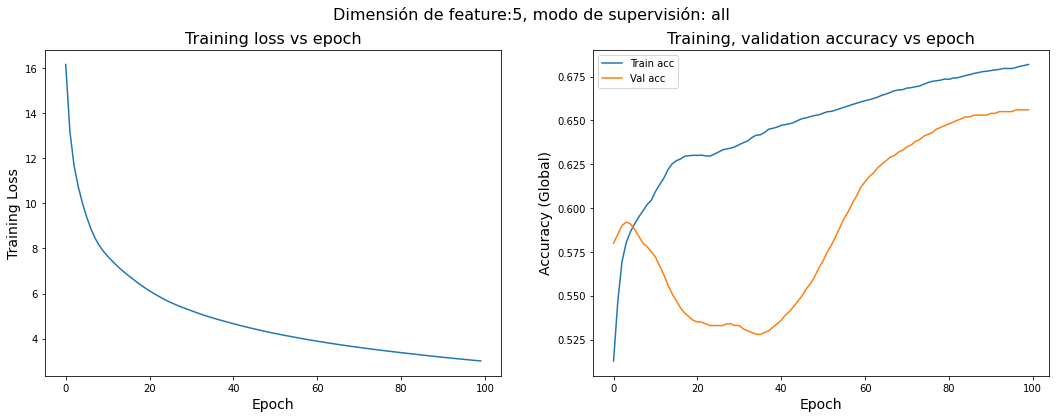

all 10
15.51065731048584
7.442861080169678
5.844393253326416
4.949707508087158
4.309467792510986
3.8622071743011475
3.525563955307007
3.273766279220581
3.0812795162200928
2.92736554145813


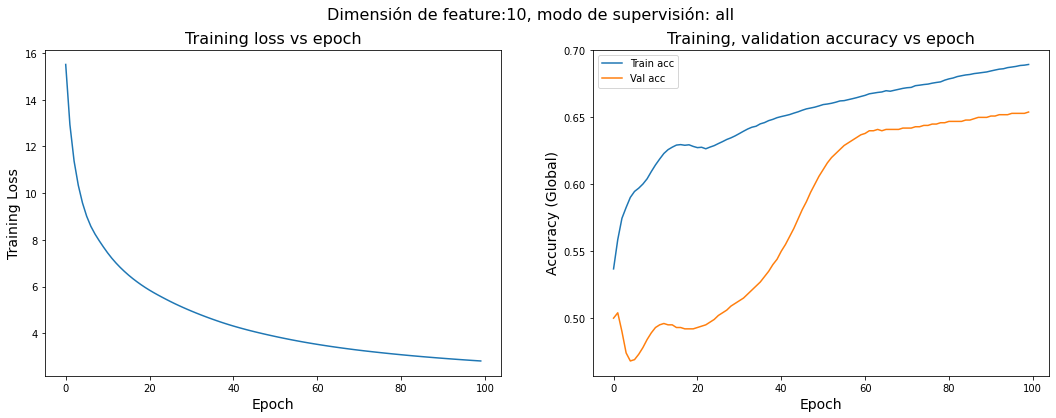

all 50
14.958513259887695
6.754513740539551
5.1808295249938965
4.2616071701049805
3.6482484340667725
3.220064401626587
2.90915584564209
2.6708590984344482
2.4757869243621826
2.313143014907837


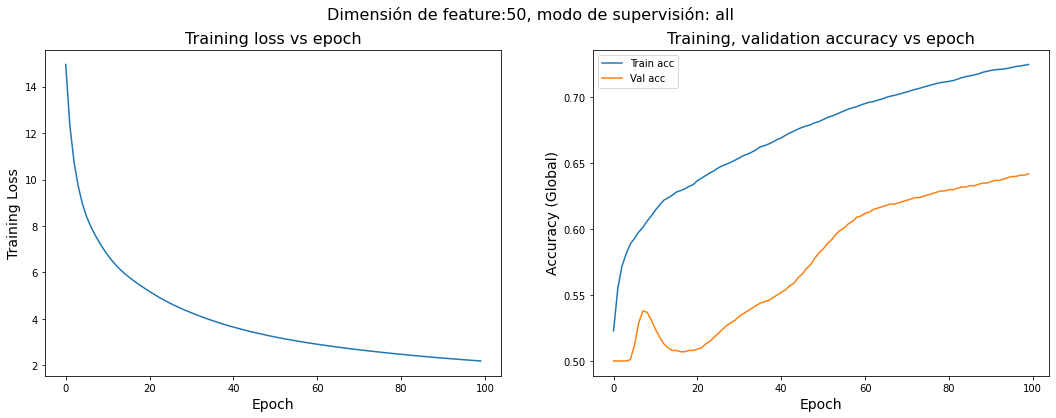

all 100
16.242568969726562
6.547583103179932
4.87117338180542
3.9073400497436523
3.2980363368988037
2.882622003555298
2.579739570617676
2.3476192951202393
2.162806272506714
2.0089542865753174


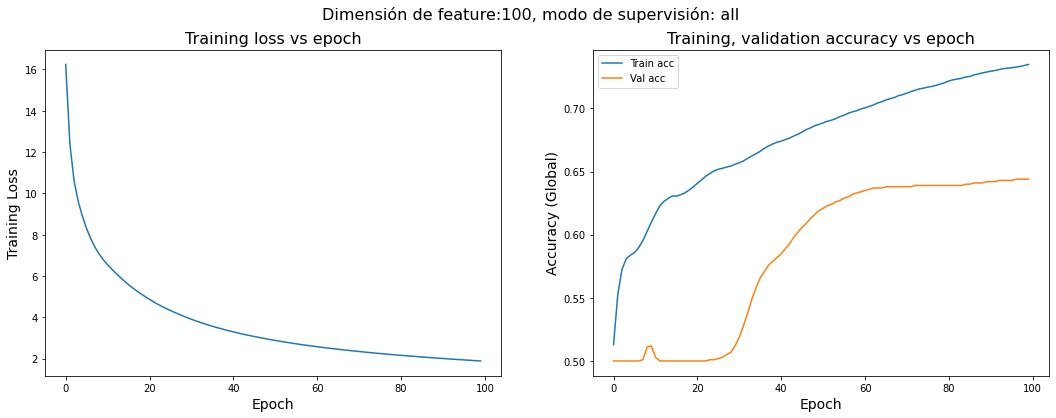

all 500
15.612603187561035
4.71523904800415
3.041863441467285
2.245781898498535
1.7685927152633667
1.4615819454193115
1.2461217641830444
1.0877748727798462
0.9656368494033813
0.8674775958061218


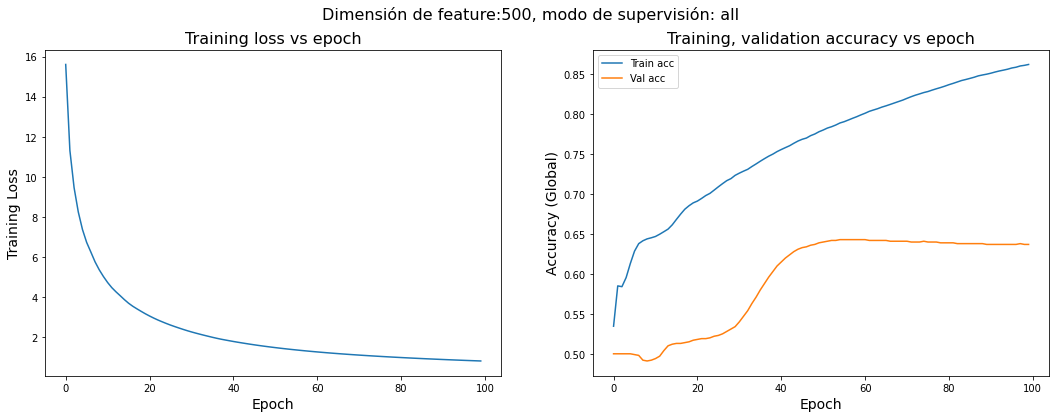

gda_only 5
4.358474254608154
1.5993690490722656
1.1959774494171143
1.0569865703582764
1.0017277002334595
0.973321795463562
0.9547085762023926
0.9404782056808472
0.9280503988265991
0.9161562323570251


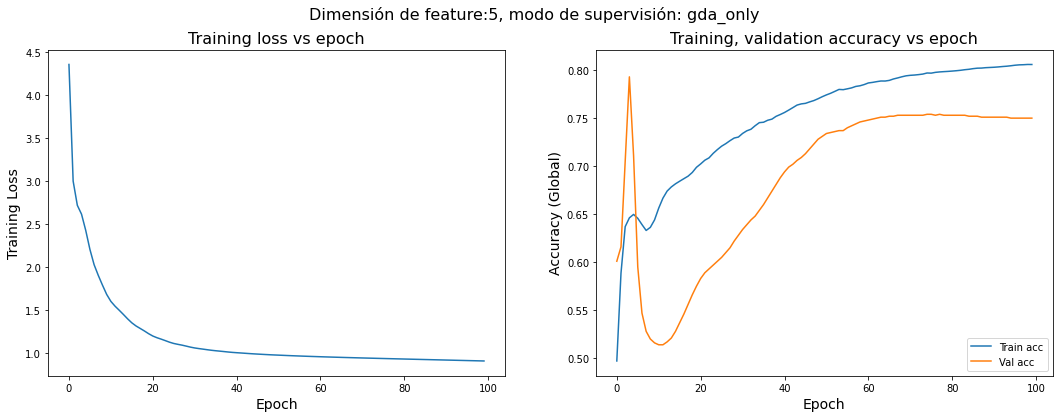

gda_only 10
4.167426109313965
1.5564334392547607
1.1369292736053467
1.0177080631256104
0.9721375703811646
0.9472127556800842
0.9280924797058105
0.9105971455574036
0.893463671207428
0.8763352632522583


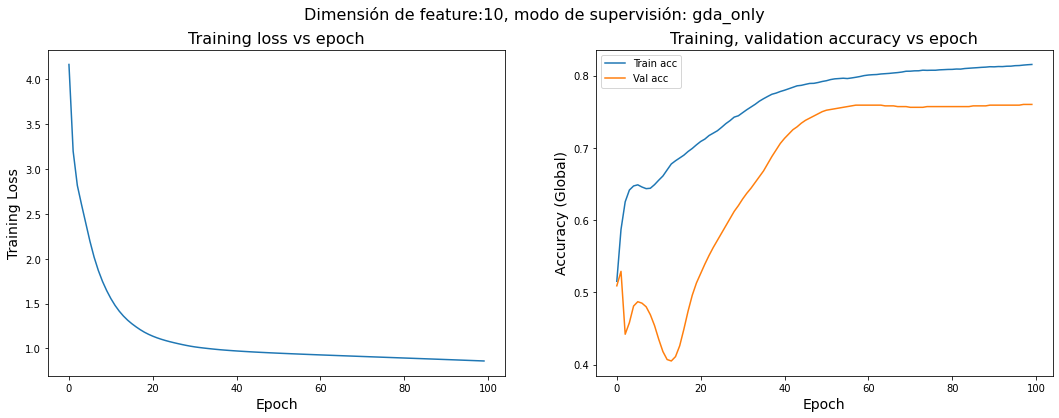

gda_only 50
4.629113674163818
1.5361442565917969
1.097740888595581
0.9961440563201904
0.9510310888290405
0.9182291030883789
0.8902865052223206
0.8639536499977112
0.8369367718696594
0.8081564903259277


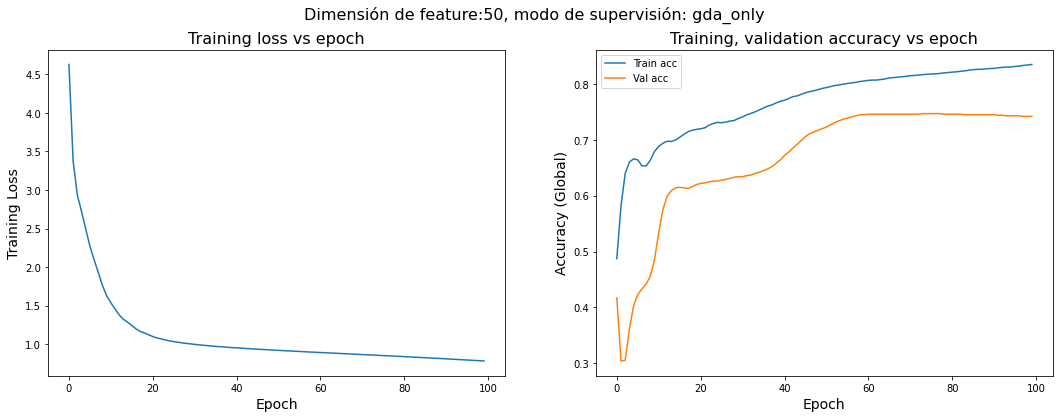

gda_only 100
4.992966651916504
1.4161369800567627
1.0365729331970215
0.9364429712295532
0.888385534286499
0.849238932132721
0.8098309636116028
0.7679284811019897
0.7227180600166321
0.6736711263656616


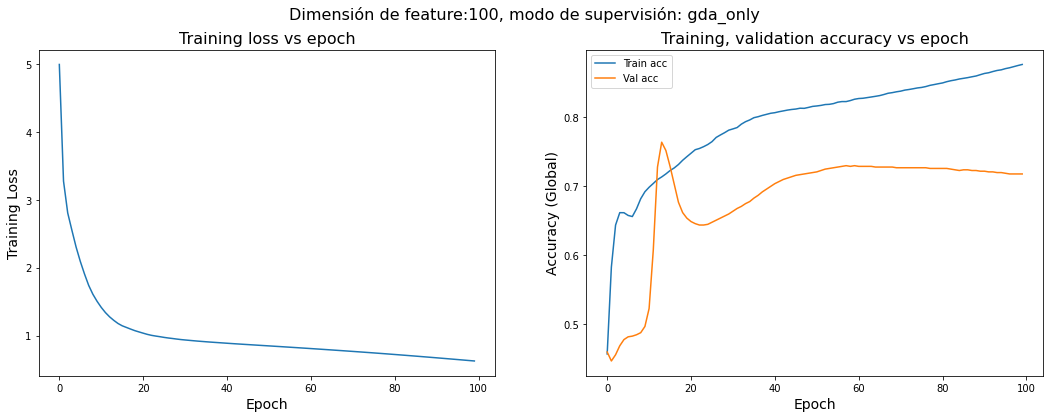

gda_only 500
5.382137298583984
1.1915339231491089
0.90476393699646
0.78485107421875
0.668168842792511
0.5460033416748047
0.4197661876678467
0.30226102471351624
0.20491623878479004
0.1341037154197693


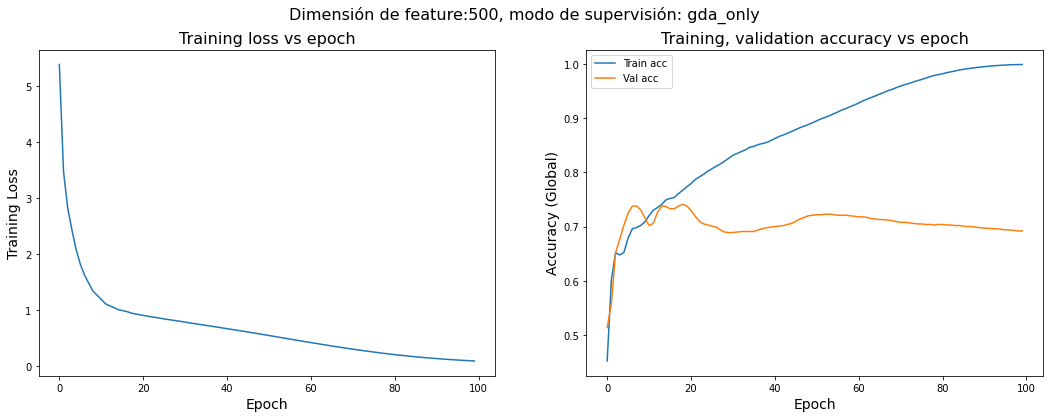

In [114]:
all_results = {}
supervision = ["all","gda_only"]
feature_len = [5,10,50,100,500]
train_mode = "disjoint"

for sup in supervision:
  for flen in feature_len:
    print(sup,flen)
    result = opt_iteration2(Hete,train_data,val_data,train_mode,sup,"dotprod",flen,"random",args)
    all_results[(sup,flen)] = result
    date = datetime.datetime.now()
    fname = date.strftime("%d_%m_%y__%I_%M")

save_results(all_results,fname)

In [115]:
all_results

{('all',
  5): {'Hits @ k': {5: {('disease', 'GDA', 'gene/protein'): {'hits': 5},
    ('disease', 'parent_child_mondo', 'disease'): {'hits': 1},
    ('gene/protein', 'GDA', 'disease'): {'hits': 2},
    ('gene/protein', 'PPI', 'gene/protein'): {'hits': 5},
    ('gene/protein', 'forms_complex', 'protein_complex'): {'hits': 4},
    ('protein_complex', 'forms_complex', 'gene/protein'): {'hits': 4}},
   10: {('disease', 'GDA', 'gene/protein'): {'hits': 10},
    ('disease', 'parent_child_mondo', 'disease'): {'hits': 1},
    ('gene/protein', 'GDA', 'disease'): {'hits': 5},
    ('gene/protein', 'PPI', 'gene/protein'): {'hits': 10},
    ('gene/protein', 'forms_complex', 'protein_complex'): {'hits': 9},
    ('protein_complex', 'forms_complex', 'gene/protein'): {'hits': 9}},
   20: {('disease', 'GDA', 'gene/protein'): {'hits': 19},
    ('disease', 'parent_child_mondo', 'disease'): {'hits': 6},
    ('gene/protein', 'GDA', 'disease'): {'hits': 9},
    ('gene/protein', 'PPI', 'gene/protein'): {'hits